In [1]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.distributed as dist
import torchvision
import torch.nn.functional as F
import json

from torch.utils.data import DataLoader

import sys
import os
sys.path.append('../VQ_SEEDLM')

from datasets_weight_vector import get_datasets
from models import VQ_SEEDLM
from utils.optimizers import *
from utils.util import *

/home/jgryu/miniconda3/envs/nicc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jgryu/miniconda3/envs/nicc/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
def parse_args(argv):
    parser = argparse.ArgumentParser(description="Example training script.")
    parser.add_argument("--dist_port", type=int, default=6006, required=True)
    parser.add_argument("--iter", default=2000000, type=int)
    parser.add_argument("--dataset_path", type=str, default="../Wparam_dataset/dataset_per_row/meta-llama/Meta-Llama-3-8B/mlp_16_row_dataset.pt")
    parser.add_argument("-lr", "--learning_rate", default=1e-4, type=float)
    parser.add_argument("-n", "--num_workers", type=int, default=2)
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--seed", type=float, default=100)
    parser.add_argument("--input_size", type=int, default=16)
    parser.add_argument("--dim_encoder", type=int, default=32)
    parser.add_argument("--P", type=int, default=4)
    parser.add_argument("--n_embeddings", type=int, default=16)
    parser.add_argument("--n_resblock", type=int, default=4)
    parser.add_argument("--vq_beta", type=float, default=0.25)
    parser.add_argument("--clip_max_norm", default=1.0, type=float)
    args = parser.parse_args(argv)
    return args

In [3]:
        # return {'embedding_loss': embedding_loss,
        #         'x': x,
        #         'x_hat': x_hat, 
        #         'perplexity': perplexity,
        #         'z_q':z_q,
        #         'min_encodings':min_encodings,
        #         'min_encoding_indices':min_encoding_indices,
        #         'coefficient':coefficient}

## num embedding에 따른 결과 분석

In [4]:
device = torch.device('cuda:0')

train_dataset, test_dataset, train_std, test_std = get_datasets("../Wparam_dataset/dataset_per_row/meta-llama/Meta-Llama-3-8B/mlp_16_row_dataset.pt")

with open('/home/jgryu/Weight_compression/Wparam_dataset/dataset_per_row/meta-llama/Meta-Llama-3-8B/mlp_16_row_dataset_stats.json', 'r', encoding='utf-8') as file:
        dataset_stats = json.load(file)  # JSON 파일을 Python 객체로 변환

# ckpt_paths = [
#         '../VQ_SEEDLM/checkpoint_save/Meta-Llama-3-8B/mlp_16_row_dataset.pt/size16_ne256_P4_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.28962_total_iter_1250000.pth.tar',
#         '../VQ_SEEDLM/checkpoint_save/Meta-Llama-3-8B/mlp_16_row_dataset.pt/size16_ne512_P4_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.11122_total_iter_2000000.pth.tar',
#         '../VQ_SEEDLM/checkpoint_save/Meta-Llama-3-8B/mlp_16_row_dataset.pt/size16_ne1024_P4_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.10727_total_iter_2000000.pth.tar',
# ]
# configs = [
#         {'size':16, 'de': 64, 'P': 4, 'ne': 256, 'nr': 4},
#         {'size':16, 'de': 64, 'P': 4, 'ne': 512, 'nr': 4},
#         {'size':16, 'de': 64, 'P': 4, 'ne': 1024, 'nr': 4},
# ]
# labels = [
#         'ne256',
#         'ne512',
#         'ne1024',
# ]
ckpt_paths = [
    '/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint_v101/Meta-Llama-3-8B/mlp_16_row_dataset.pt_v101/size16_ne256_de256_P4_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.09639_total_iter_2000000.pth.tar',
    '/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint_v101/Meta-Llama-3-8B/mlp_16_row_dataset.pt_v101/size16_ne512_de256_P4_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.0864_total_iter_2000000.pth.tar',
    '/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint_v101/Meta-Llama-3-8B/mlp_16_row_dataset.pt_v101/size16_ne512_de256_P8_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.00338_total_iter_1950000.pth.tar',
    '/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint_v101/Meta-Llama-3-8B/mlp_16_row_dataset.pt_v101/size16_ne512_de256_P16_batch_size512_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_2e-05_total_iter_1850000.pth.tar'
]

configs  = [
    {'size': 16, 'de': 256, 'P': 4, 'ne':256, 'nr':4},
    {'size': 16, 'de': 256, 'P': 4, 'ne':512, 'nr':4},
    {'size': 16, 'de': 256, 'P': 8, 'ne':512, 'nr':4},
    {'size': 16, 'de': 256, 'P': 16, 'ne':512, 'nr':4},
]
labels = [
        '6',
        '6.25',
        '12.5',
        '20.5',
]
results = {}

for ckpt_path, config, l in zip(ckpt_paths, configs, labels):
        ckpt = torch.load(ckpt_path)

                
        model = VQ_SEEDLM(input_size = config['size'], 
                        dim_encoder = config['de'], 
                        P = config['P'], 
                        n_embeddings = config['ne'], 
                        n_resblock = config['nr'], 
                        beta = 0.25,
                        scale = torch.Tensor(dataset_stats['train']['mean_channel']).to(device), 
                        shift = torch.Tensor(dataset_stats['train']['mean_channel']).to(device)
                        )

        model.load_state_dict(ckpt['state_dict'])
        model.to(device)

        mean_MSE = 0
        mse_func = torch.nn.MSELoss()

        device = next(model.parameters()).device

        out_list = []
        for idx, weight in enumerate(test_dataset) :
                weight = weight.to(device)
                x = weight.unsqueeze(0).to(device) # [1, 512, 512] 같음
                out = model(x.to(device))
                out_list.append(out)
                
                x_hat = out["x_hat"].clone().detach()
                mse = mse_func(x, x_hat).item()
                mean_MSE += mse
        
        mean_MSE /= len(test_dataset)
        results[l] = out_list
        

/home/jgryu/Weight_compression/notebooks/../VQ_SEEDLM/datasets_weight_vector.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(dataset_folder_path)
/tmp

6


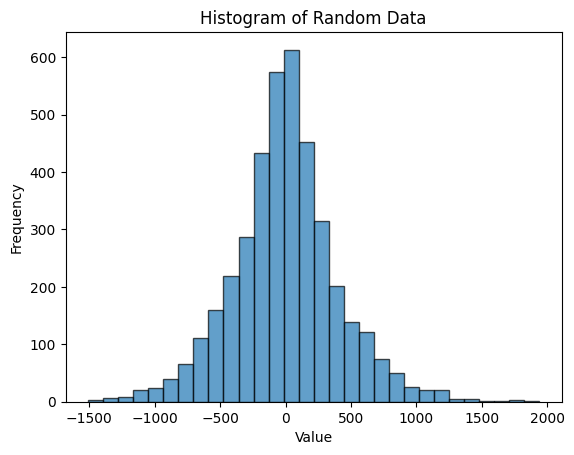

tensor(-2.4264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1936.6283, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1507.3877, device='cuda:0', grad_fn=<MinBackward1>)
6.25


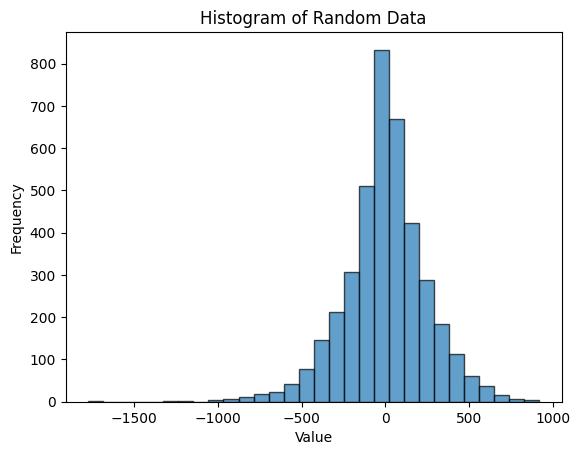

tensor(-2.4396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(918.9112, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1775.6094, device='cuda:0', grad_fn=<MinBackward1>)
12.5


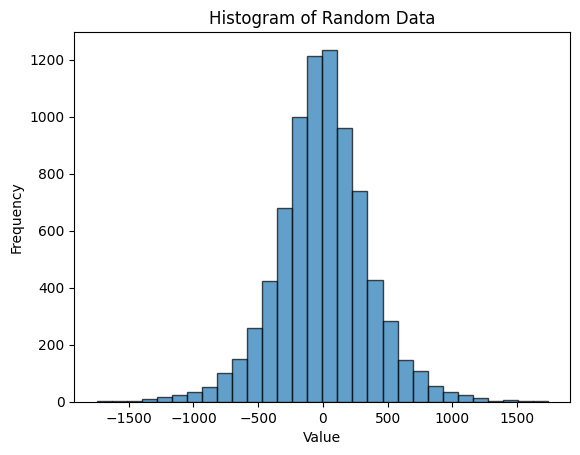

tensor(-0.2651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1737.2271, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1745.6265, device='cuda:0', grad_fn=<MinBackward1>)
20.5


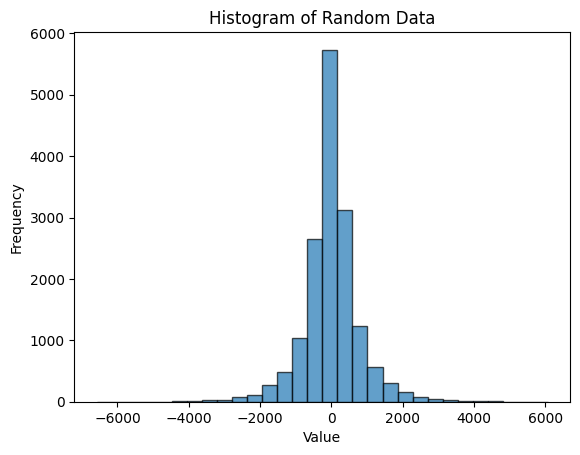

tensor(1.6333, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6066.9360, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6575.9106, device='cuda:0', grad_fn=<MinBackward1>)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

for l in labels:
    print(l)
    out_list = results[l]
    coeffs = []
    for i in out_list:
        coeffs.append(i['coefficient'])
    coeffs = torch.cat(coeffs, dim=0)

    plt.hist(coeffs.view(-1).cpu().detach().numpy(), bins=30, edgecolor='black', alpha=0.7)

    # Add labels and title
    plt.title("Histogram of Random Data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Show the plot
    plt.show()

    print(coeffs.mean())
    print(coeffs.max())
    print(coeffs.min())

In [ ]:
sorted(torch.abs(coeffs).view(-1).tolist())

[0.002550370991230011,
 0.007743619382381439,
 0.02694467455148697,
 0.03039328008890152,
 0.05987044423818588,
 0.1947009265422821,
 0.22932219505310059,
 0.28359749913215637,
 0.28499242663383484,
 0.29163795709609985,
 0.3165433704853058,
 0.350576251745224,
 0.36501678824424744,
 0.4002707898616791,
 0.49022307991981506,
 0.5112163424491882,
 0.5239406228065491,
 0.6135068535804749,
 0.6390882134437561,
 0.6781908869743347,
 0.6886674165725708,
 0.7059186100959778,
 0.7083359956741333,
 0.7382889986038208,
 0.7458472847938538,
 0.7695514559745789,
 0.8302721977233887,
 0.8626076579093933,
 0.8767735958099365,
 0.9443891048431396,
 0.9507291316986084,
 0.9553911685943604,
 0.9873965978622437,
 1.047518014907837,
 1.0562361478805542,
 1.0983288288116455,
 1.1153414249420166,
 1.1482741832733154,
 1.1484419107437134,
 1.1706739664077759,
 1.1890641450881958,
 1.1903917789459229,
 1.1988180875778198,
 1.2546191215515137,
 1.291959285736084,
 1.3469806909561157,
 1.3488080501556396,
 1.

: 

6


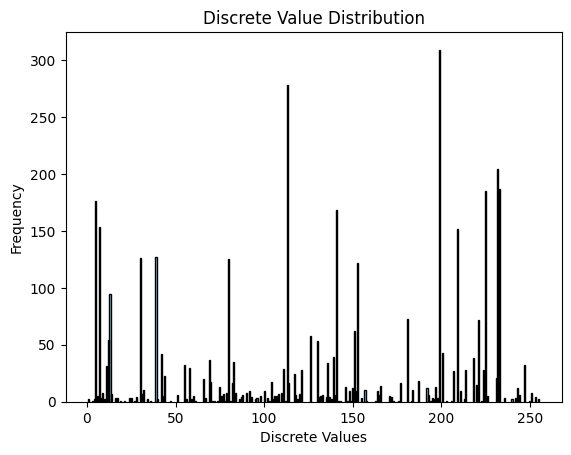

tensor(255, device='cuda:0')
tensor(1, device='cuda:0')
빈도수가 0이 아닌 값의 개수: 157
6.25


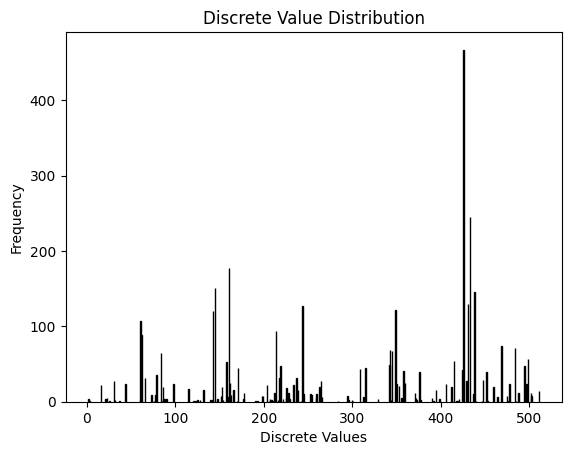

tensor(511, device='cuda:0')
tensor(2, device='cuda:0')
빈도수가 0이 아닌 값의 개수: 144
12.5


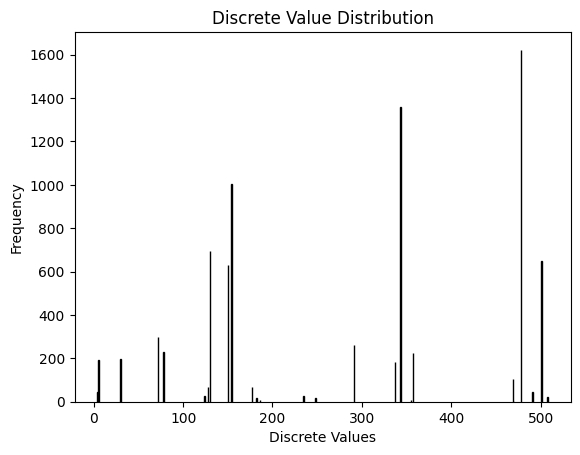

tensor(508, device='cuda:0')
tensor(4, device='cuda:0')
빈도수가 0이 아닌 값의 개수: 26
20.5


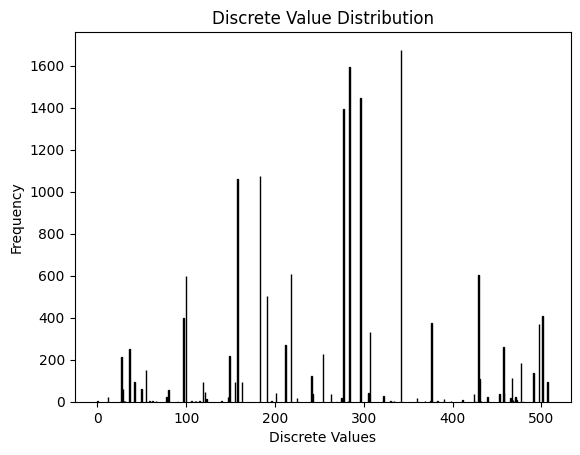

tensor(507, device='cuda:0')
tensor(0, device='cuda:0')
빈도수가 0이 아닌 값의 개수: 100


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

for l in labels:
    print(l)
    out_list = results[l]
    ids = []
    for i in out_list:
        ids.append(i['min_encoding_indices'])
    ids = torch.cat(ids, dim=0)

    counter = Counter(ids.view(-1).cpu().detach().numpy())  # Counter 객체를 사용하여 빈도 계산
    x_values = list(counter.keys())  # 데이터 값 (x축)
    y_values = list(counter.values())  # 빈도수 (y축)

    # 막대 그래프 그리기
    plt.bar(x_values, y_values, width=0.6, color='skyblue', edgecolor='black')

    # 그래프 꾸미기
    plt.title("Discrete Value Distribution")
    plt.xlabel("Discrete Values")
    plt.ylabel("Frequency")
    # plt.xticks(x_values)  # x축 눈금을 이산 값에 맞춤

    # 그래프 표시
    plt.show()

    # print(ids.mean())
    print(ids.max())
    print(ids.min())
    
    non_zero_count = sum(1 for count in counter.values() if count > 0)

    print("빈도수가 0이 아닌 값의 개수:", non_zero_count)


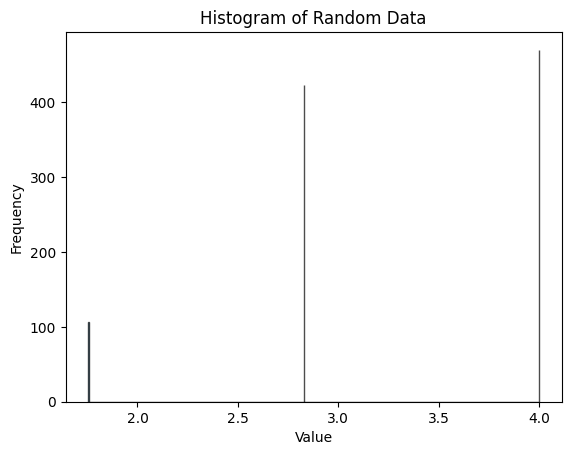

3.26418455016613
4.0
1.7547653913497925


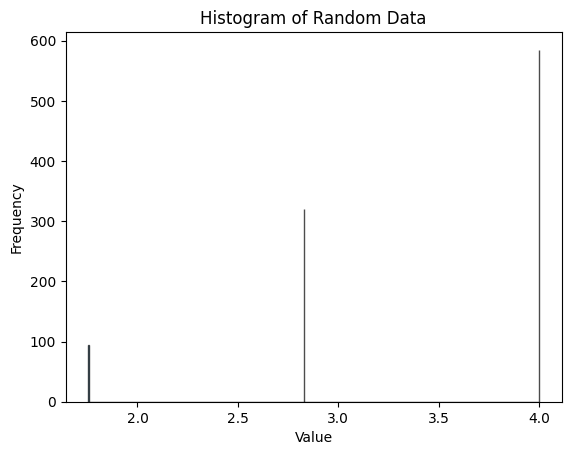

3.4128730382919312
4.0
1.7547653913497925


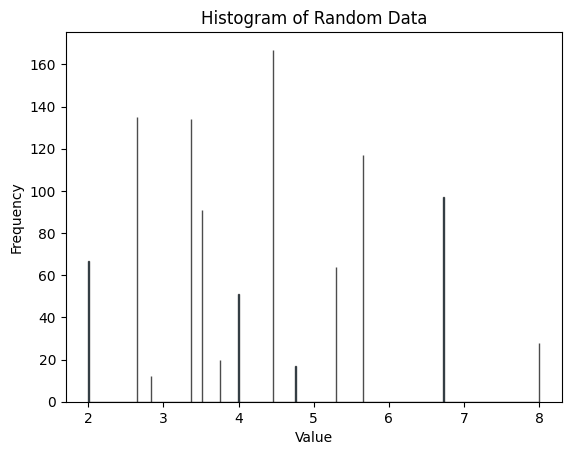

4.277092089414596
8.0
2.0


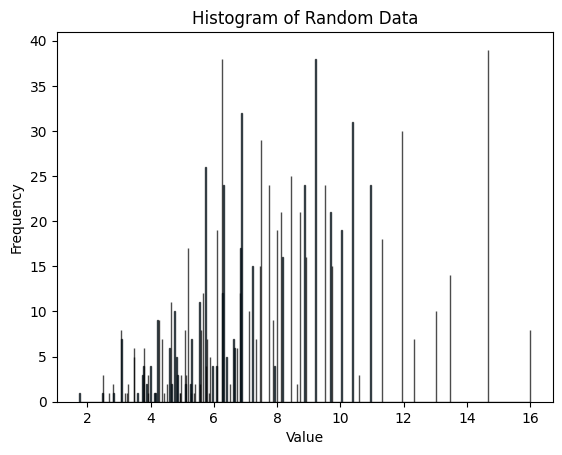

7.885325188040733
16.0
1.7547653913497925


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

for l in labels:
    out_list = results[l]
    ids = []
    for i in out_list:
        ids.append(i['perplexity'].item())
    # ids = torch.cat(ids, dim=0)

    plt.hist(ids, bins=1000, edgecolor='black', alpha=0.7)

    # Add labels and title
    plt.title("Histogram of Random Data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Show the plot
    plt.show()

    ids = np.array(ids)
    print(ids.mean())
    print(ids.max())
    print(ids.min())